In [1]:
# Imports
import numpy as np
import copy as cp

# Mujoco
import mujoco
import mujoco_viewer

# Controller functions
from control.controllers.mppi_locomotion import MPPI

from utils.tasks import get_task
from utils.transforms import batch_world_to_local_velocity

# Visualization
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt

## Choose task
* `'stand'`
* `'walk_straight'`
* `'walk_octagon'`
* `'big_box'`
* `'stairs'`

In [2]:
# Task
task = 'walk_straight'
task_data = get_task(task)
model_path = task_data['sim_path']

In [3]:
# Model visualizer
model_sim = mujoco.MjModel.from_xml_path(model_path)
dt_sim = 0.01
model_sim.opt.timestep = dt_sim
data_sim = mujoco.MjData(model_sim)
viewer = mujoco_viewer.MujocoViewer(model_sim, data_sim, 'offscreen')

In [4]:
# Reset robot (keyframes are defined in the xml)
mujoco.mj_resetDataKeyframe(model_sim, data_sim, 0) # stand position
mujoco.mj_forward(model_sim, data_sim)
q_init = cp.deepcopy(data_sim.qpos) # save reference pose
v_init = cp.deepcopy(data_sim.qvel) # save reference pose
print("Configuration: {}".format(q_init)) # save reference pose

Configuration: [ 0.    0.    0.26  1.    0.    0.    0.    0.    0.9  -1.8   0.    0.9
 -1.8   0.    0.9  -1.8   0.    0.9  -1.8 ]


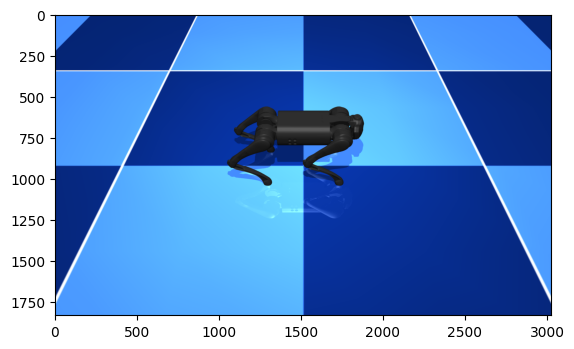

In [5]:
img = viewer.read_pixels()
plt.imshow(img)

In [6]:
# Initialize controller
controller = MPPI(task=task)
controller.internal_ref = True
controller.reset_planner()

Task:  walk_straight
Initial goal 0: [0, 0, 0.27]
Initial gait in_place


In [7]:
q_curr = cp.deepcopy(data_sim.qpos) # save reference pose
v_curr = cp.deepcopy(data_sim.qvel) # save reference pose
x = np.concatenate([q_curr, v_curr])

In [8]:
# Set simulation time
tfinal = 8 # 14 for stairs, 30 for walk_octagon
tvec = np.linspace(0,tfinal,int(np.ceil(tfinal/dt_sim))+1)

In [9]:
mujoco.mj_resetDataKeyframe(model_sim, data_sim, 1)
mujoco.mj_forward(model_sim, data_sim)

In [10]:
viewer.cam.distance = 4.2
viewer.cam.lookat[:] = [2.2, 0, 0.27]

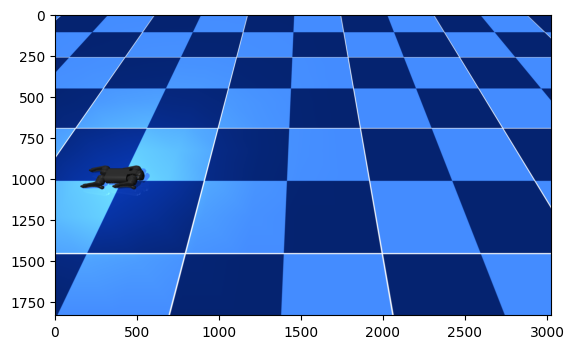

In [11]:
img = viewer.read_pixels()
plt.imshow(img)

In [12]:
np.zeros(len(controller.goal_pos))

array([0., 0., 0.])

In [13]:
%%time
# Run simulation
anim_imgs = []
sim_inputs = []
x_states = []
error_history = []
max_cost_history = []
min_cost_history = []
cost_norm_history = []
num_iter_per_goal = np.zeros(len(controller.goal_pos))

for ticks, ti in enumerate(tvec):
    q_curr = cp.deepcopy(data_sim.qpos) # save reference pose
    v_curr = cp.deepcopy(data_sim.qvel) # save reference pose
    x = np.concatenate([q_curr, v_curr])
    
    if ticks%1 == 0:
        u_joints, cost_info = controller.update(x)  
        max_cost_history.append(cost_info['max_cost'])
        min_cost_history.append(cost_info['min_cost'])
        cost_norm_history.append(np.linalg.norm(cost_info['max_cost'] - cost_info['min_cost']))

    data_sim.ctrl[:] = u_joints
    mujoco.mj_step(model_sim, data_sim)
    mujoco.mj_forward(model_sim, data_sim)

    error = np.linalg.norm(np.array(controller.body_ref[:3]) - np.array(data_sim.qpos[:3]))
    error_history.append(error)
    
    viewer.add_marker(
        pos=controller.body_ref[:3]*1,         # Position of the marker
        size=[0.15, 0.15, 0.15],     # Size of the sphere
        rgba=[1, 0, 1, 1],           # Color of the sphere (red)
        type=mujoco.mjtGeom.mjGEOM_SPHERE, # Specify that this is a sphere
        label=""
    )

    if error < controller.goal_thresh[controller.goal_index]:
        controller.next_goal()
    
    num_iter_per_goal[controller.goal_index] += 1
    
    img = viewer.read_pixels()
    if ticks % 2 == 0:
        anim_imgs.append(img)
    sim_inputs.append(u_joints)
    x_states.append(x)

Moved to next goal 1: [1, 0, 0.27]
Gait: walk_fast
Moved to next goal 2: [1, 0, 0.27]
Gait: in_place
Task succeeded.
CPU times: user 33.6 s, sys: 1.29 s, total: 34.9 s
Wall time: 19 s


In [14]:
controller.goal_pos

[[0, 0, 0.27], [1, 0, 0.27], [1, 0, 0.27]]

/var/folders/f4/tmzc6_zx1s72mwkptr53qyp40000gn/T/ipykernel_70187/3860294387.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


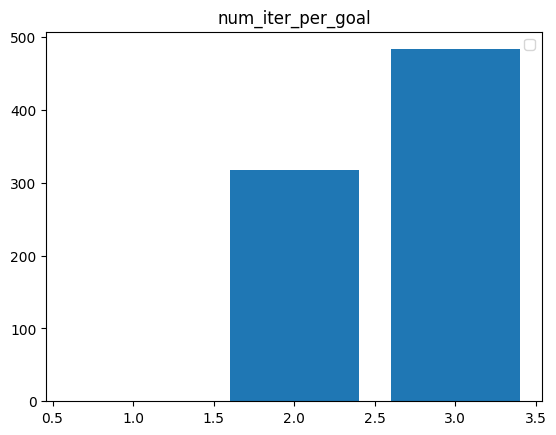

In [15]:
plt.bar([1,2,3],num_iter_per_goal)
plt.title("num_iter_per_goal")
plt.legend()

/var/folders/f4/tmzc6_zx1s72mwkptr53qyp40000gn/T/ipykernel_70187/2154609937.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


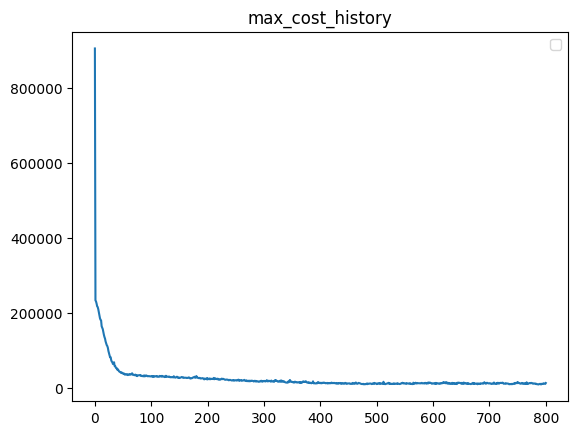

In [16]:
plt.plot(max_cost_history)
plt.title("max_cost_history")
plt.legend()

/var/folders/f4/tmzc6_zx1s72mwkptr53qyp40000gn/T/ipykernel_70187/2543610374.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


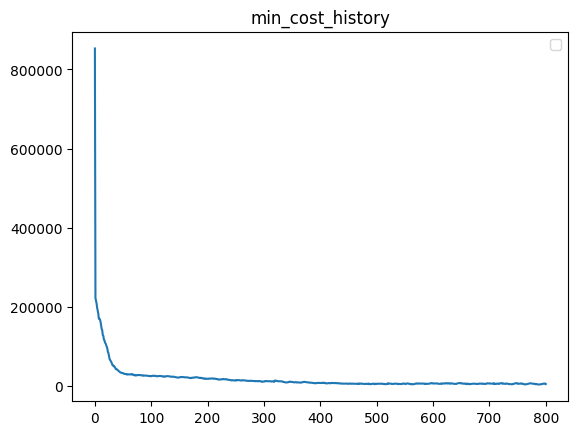

In [17]:
plt.plot(min_cost_history)
plt.title("min_cost_history")
plt.legend()

/var/folders/f4/tmzc6_zx1s72mwkptr53qyp40000gn/T/ipykernel_70187/508193682.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


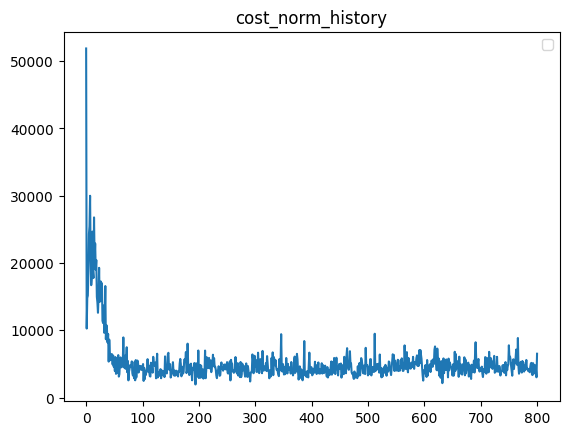

In [18]:
plt.plot(cost_norm_history)
plt.title("cost_norm_history")
plt.legend()

/var/folders/f4/tmzc6_zx1s72mwkptr53qyp40000gn/T/ipykernel_70187/4135399545.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


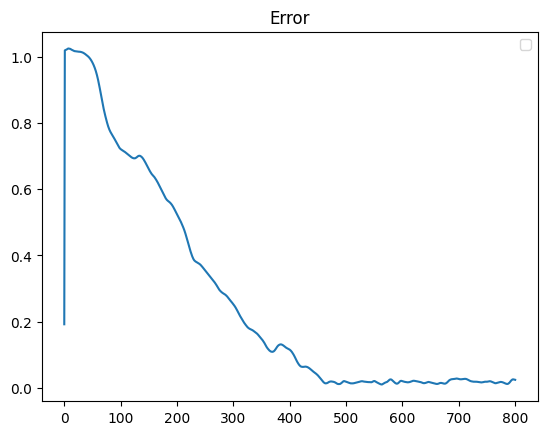

In [19]:
plt.plot(error_history)
plt.title("Error")
plt.legend()

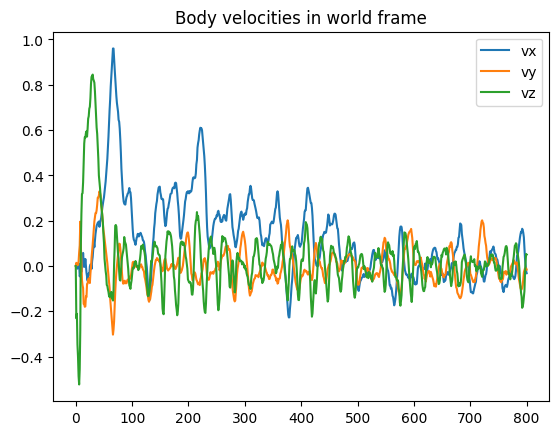

In [20]:
x_states_np = np.array(x_states)
orientations = x_states_np[:,3:7]
velocities = x_states_np[:,19:22]
velocities_trans = batch_world_to_local_velocity(orientations, velocities)

plt.plot(velocities_trans, label=["vx", "vy", "vz"])
plt.title("Body velocities in world frame")
plt.legend()

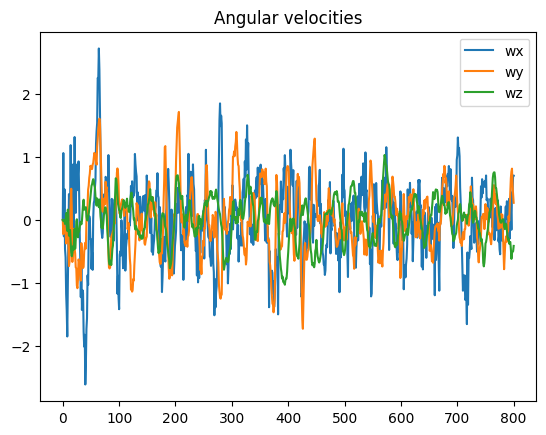

In [21]:
angular_velocities = x_states_np[:,22:25]
plt.plot(angular_velocities, label=["wx", "wy", "wz"])
plt.title("Angular velocities")
plt.legend()

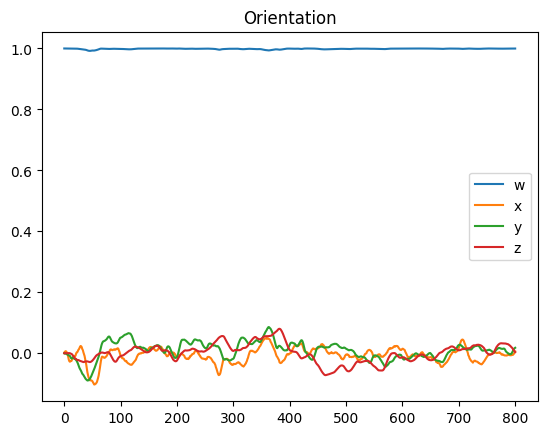

In [22]:
plt.plot(orientations, label=["w", "x", "y", "z"])
plt.title("Orientation")
plt.legend()

Text(0.5, 1.0, 'Joint angles FR leg')

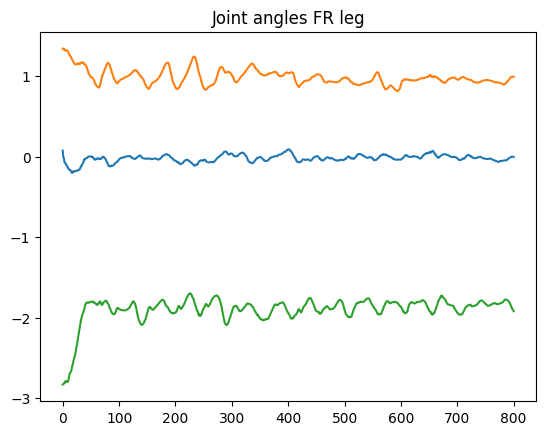

In [23]:
plt.plot(x_states_np[:,7:10], label=["hip","thigh","calf"])
plt.title("Joint angles FR leg")

Text(0.5, 1.0, 'Joint angles FL leg')

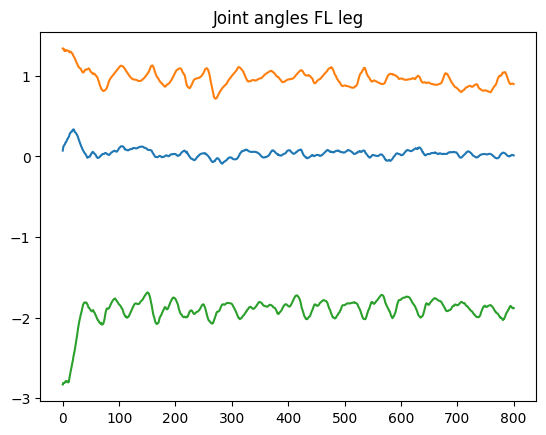

In [24]:
plt.plot(x_states_np[:,10:13], label=["hip","thigh","calf"])
plt.title("Joint angles FL leg")

Text(0.5, 1.0, 'Joint angles RR leg')

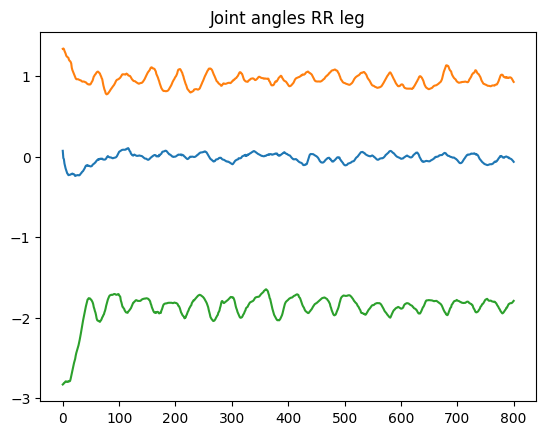

In [25]:
plt.plot(x_states_np[:,13:16], label=["hip","thigh","calf"])
plt.title("Joint angles RR leg")

Text(0.5, 1.0, 'Joint angles RL leg')

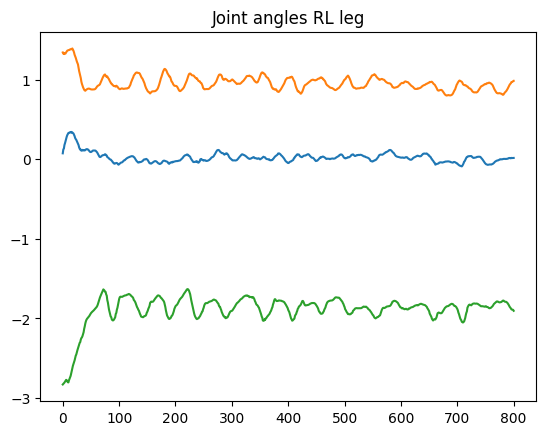

In [26]:
plt.plot(x_states_np[:,16:19], label=["hip","thigh","calf"])
plt.title("Joint angles RL leg")

In [27]:
sim_inputs_np = np.array(sim_inputs)

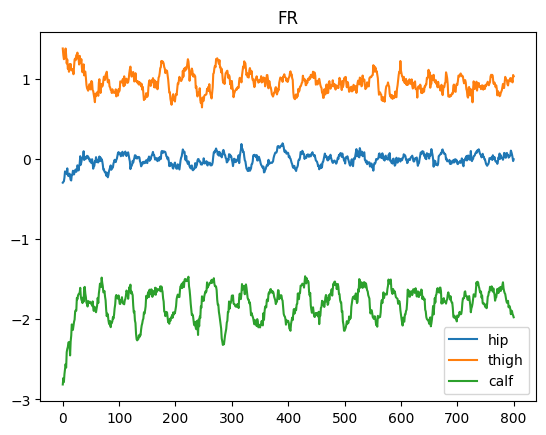

In [28]:
plt.plot(sim_inputs_np[:,0:3], label=["hip", "thigh", "calf"])
plt.title("FR")
plt.legend()

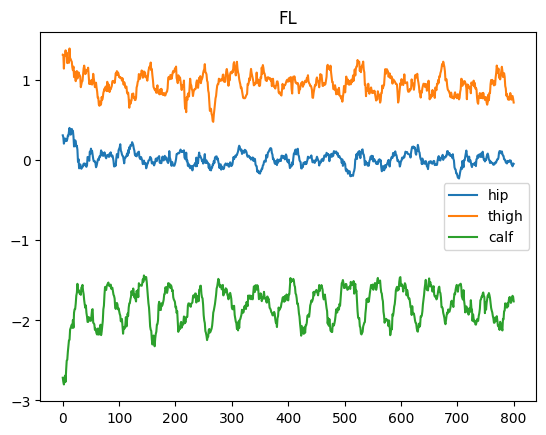

In [29]:
plt.plot(sim_inputs_np[:,3:6], label=["hip", "thigh", "calf"])
plt.title("FL")
plt.legend()

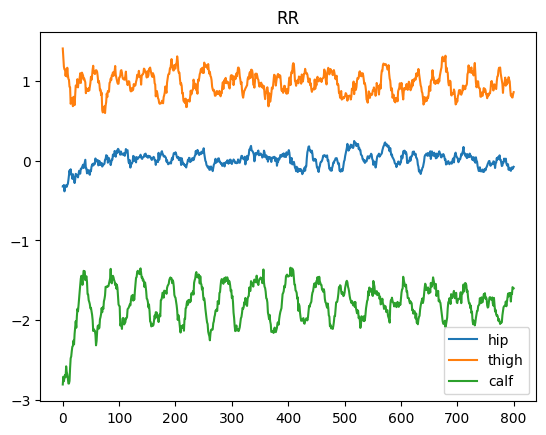

In [30]:
plt.plot(sim_inputs_np[:,6:9], label=["hip", "thigh", "calf"])
plt.title("RR")
plt.legend()

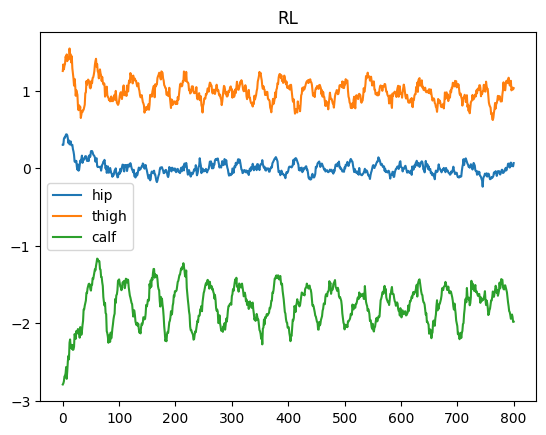

In [31]:
plt.plot(sim_inputs_np[:,9:], label=["hip", "thigh", "calf"])
plt.title("RL")
plt.legend()

## Animation

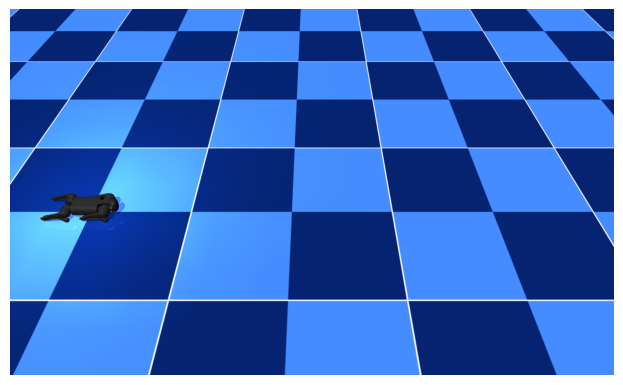

In [32]:
# Get the resolution of the images
image_height, image_width = anim_imgs[0].shape[:2]

# Set the figure size to match the image resolution
fig, ax = plt.subplots(figsize=(image_width / 500, image_height / 500), dpi=100)
skip_frames = 5
interval = dt_sim*1000*skip_frames
# Remove the white border by setting margins and padding to zero
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax.set_position([0, 0, 1, 1])

def animate(i):
    ax.clear()
    ax.imshow(anim_imgs[i * skip_frames])  # Display the image, skipping frames
    ax.axis('off')

# Create animation, considering the reduced frame rate due to skipped frames
ani = FuncAnimation(fig, animate, frames=len(anim_imgs) // skip_frames, interval=interval)  # 50 ms for 20 Hz

# Display the animation
HTML(ani.to_jshtml())

In [33]:
# Save the animation
ani.save('{}.mov'.format(task), writer='ffmpeg', fps=20, codec='prores', bitrate=-1, extra_args=['-pix_fmt', 'yuv420p'])

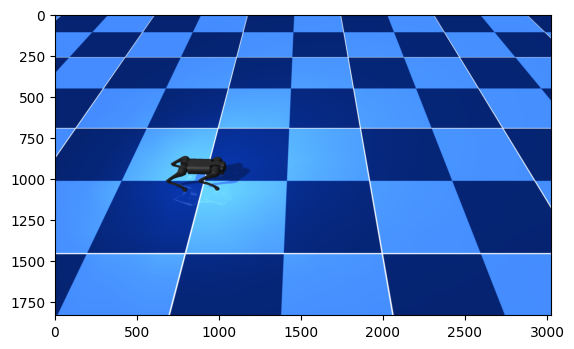

In [34]:
plt.imshow(anim_imgs[-1])